In [4]:
import json
with open('data/go_bench/molecular_function_terms.json') as f:
    go_terms = json.load(f)
import numpy as np
g = np.random.default_rng(seed=80)
subsample_indices = np.arange(len(go_terms))
g.shuffle(subsample_indices)
subsample_indices = np.sort(subsample_indices[:len(go_terms)//2])
subsample_terms = [go_terms[i] for i in subsample_indices]
# with open('data/go_bench/subsample_molecular_function_terms.json', 'w') as f:
#     json.dump(subsample_terms, f)
# with open('data/go_bench/subsample_molecular_function_terms.json', 'r') as f:
#     subsample_terms_save = json.load(f)

In [6]:
unsampled_terms = [term for term in go_terms if not term in subsample_terms ]
unsampled_indices = np.array([go_terms.index(term) for term in unsampled_terms])

# Get subset results

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import os, json
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support
from go_bench.metrics import threshold_stats

def load_annot_matrix(term_path, annot_path, seq_path):
    with open(term_path, 'r') as f:
        go_terms = json.load(f)
    annot_dict = load_GO_tsv_file(annot_path)
    dict_ids = list(annot_dict.keys())
    annot_seqs, annot_ids = load_protein_sequences(seq_path, set(dict_ids))
    annot_mat = convert_to_sparse_matrix(annot_dict, go_terms, annot_ids)
    return go_terms, annot_ids, annot_seqs, annot_mat

test_go_terms, test_ids, _, test_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/testing_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

with open("/home/andrew/GO_benchmarking/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}
# from qtlsearch.OBOParser import OBO
# go = OBO('/home/andrew/GO_benchmarking/data/go.obo.gz', store_as_int=True)
test_ia = np.zeros(len(test_go_terms))
for i, test_id in enumerate(test_go_terms):
    id_int = int(test_id[3:])
    if(id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]

In [9]:
train_path = "/home/andrew/go_metric/data/go_bench"
train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 64, "collate_fn":collate_seqs}
train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params, num_workers=6)
test_loader = DataLoader(test_dataset, **val_dataloader_params, num_workers=6)

In [6]:
from go_metric.models.bert_emb import ProtBertBFDClassifier
import pickle
with open("checkpoints/bert_emb_sample_hparams.pkl", "rb") as f:
    hparams = pickle.load(f)
model = ProtBertBFDClassifier.load_from_checkpoint("checkpoints/bert_emb_sample.ckpt", hparams=hparams)
model.eval()
device = torch.device('cuda:0')
model.to(device)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



-- Encoder model fine-tuning


ProtBertBFDClassifier(
  (ProtBertBFD): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

In [7]:
def get_sparse_probs_bert(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_id"]
            inputs, mask, y = d['seq'].to(device), d['mask'].to(device), d['labels'].to(device)
            prot_ids.extend(prot_id_l)
            m_probs = model.forward(inputs, None, mask)
            torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(new_probs)
    probs = vstack(probs_list)
    return prot_ids, probs

# val_ids, val_probs = get_sparse_probs_bert(model, val_loader)
val_ids, test_probs = get_sparse_probs_bert(model, test_loader)
import pickle
with open("paper_result_predictions/bert_finetune_sample.pkl", "wb") as f:
    pickle.dump({"prot_ids": val_ids, "probs": test_probs}, f)

In [10]:
import pickle

with open("emb/rostlab_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/sample_finetune_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_sample_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/sample_finetune_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_sample_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/sample_finetune_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_sample_embeddings = emb_dict['prot_id'], emb_dict['embedding']

from go_metric.multilabel_knn import embedding_knn
train_labels = train_dataset.labels.toarray()
test_labels = test_dataset.labels.toarray()

rostlab_preds = embedding_knn(train_embeddings, test_embeddings, train_labels, k=10)
sample_knn_preds = embedding_knn(train_sample_embeddings, test_sample_embeddings, train_labels, k=10)

In [11]:
with open("paper_result_predictions/bert_finetune_sample.pkl", "rb") as f:
    ft_preds = pickle.load(f)['probs']

with open("paper_result_predictions/blast.pkl", "rb") as f:
    blast_preds = pickle.load(f)['probs']

# print(ft_preds.shape, blast_preds.shape)
insample_ia = test_ia[subsample_indices]
outsample_ia = test_ia[unsampled_indices]

insample_labels = test_labels[:, subsample_indices]
outsample_labels = test_labels[:, unsampled_indices]

insample_stats = {"BERT-Emb": threshold_stats(insample_labels, csr_matrix(rostlab_preds[:, subsample_indices]), insample_ia),
                  "BERT-FT": threshold_stats(insample_labels, csr_matrix(ft_preds), insample_ia),
                  "BERT-FT-Emb": threshold_stats(insample_labels, csr_matrix(sample_knn_preds[:, subsample_indices]), insample_ia), 
                  "BLAST": threshold_stats(insample_labels, csr_matrix(blast_preds[:, subsample_indices]), insample_ia)
                  }
outsample_stats = {"BERT-Emb": threshold_stats(outsample_labels, csr_matrix(rostlab_preds[:, unsampled_indices]), outsample_ia),
                  "BERT-FT-Emb": threshold_stats(outsample_labels, csr_matrix(sample_knn_preds[:, unsampled_indices]), outsample_ia), 
                  "BLAST": threshold_stats(outsample_labels, csr_matrix(blast_preds[:, unsampled_indices]), outsample_ia)
                  }

In [13]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()

def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3)


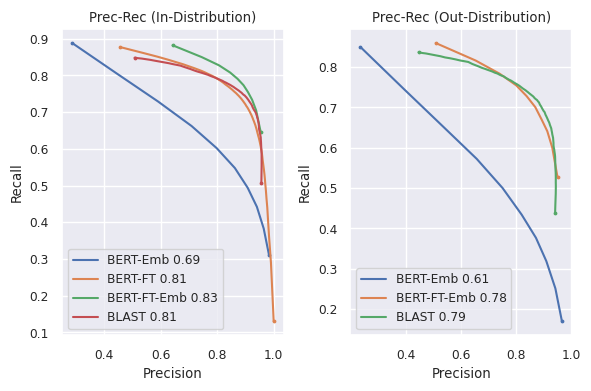

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

fig.suptitle("Hold-Out Molecular Function Performance")
for model_name, stats in insample_stats.items():
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
axes[0].set_xlabel("Precision")
axes[0].set_ylabel("Recall")
axes[0].set_title("Prec-Rec (In-Distribution)")

for model_name, stats in outsample_stats.items():
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[1], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
axes[1].set_xlabel("Precision")
axes[1].set_ylabel("Recall")
axes[1].set_title("Prec-Rec (Out-Distribution)")

axes[0].legend()
axes[1].legend()

fig.tight_layout()
fig.show()



(3,)


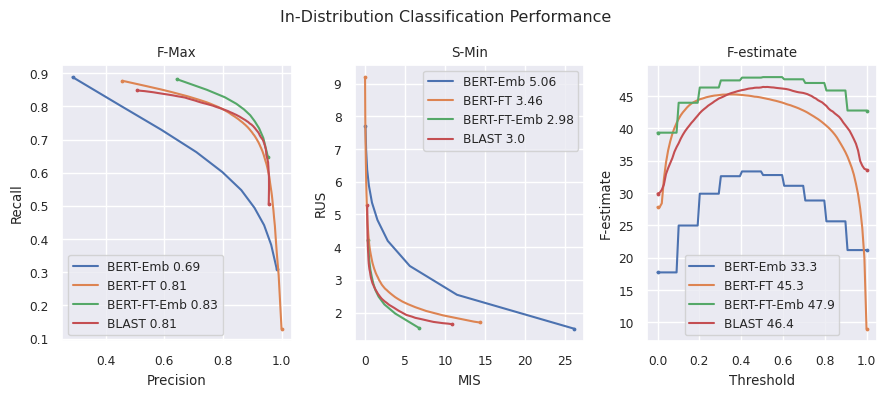

In [14]:

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("In-Distribution Classification Performance")

# base_models = ["BLAST", "Conv", "BERT-Emb", "BERT-FT", "Naive"]
# disp_info = {
#     "BLAST": colors[0],
#     "Conv": colors[1],
#     "BERT-Emb": colors[-1],
#     "BERT-FT": colors[2],
#     "Naive": colors[4]
# }
for model_name, stats in insample_stats.items():
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Recall")

    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}")
    axes[1].set_xlabel("MIS")
    axes[1].set_ylabel("RUS")

    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}")
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("F-estimate")

# axes[0].set_xlim([0.25, 1])
# axes[0].set_ylim([0, 0.9])
# axes[1].set_xlim([-3, 50])
# axes[1].set_ylim([2, 20])
# axes[2].set_xlim([0, 1.1])
# axes[2].set_ylim([0, 60])

axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()

(3,)


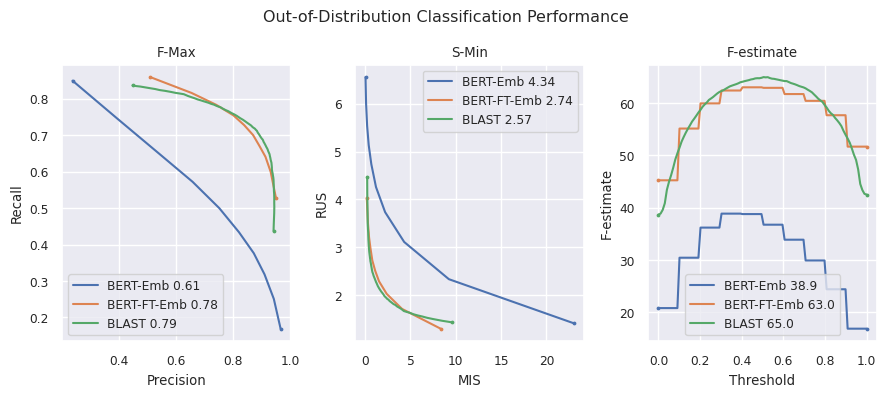

In [15]:
def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("Out-of-Distribution Classification Performance")

for model_name, stats in outsample_stats.items():
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Recall")

    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}")
    axes[1].set_xlabel("MIS")
    axes[1].set_ylabel("RUS")

    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}")
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("F-estimate")

# axes[0].set_xlim([0.25, 1])
# axes[0].set_ylim([0, 0.9])
# axes[1].set_xlim([-3, 50])
# axes[1].set_ylim([2, 20])
# axes[2].set_xlim([0, 1.1])
# axes[2].set_ylim([0, 60])

axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()

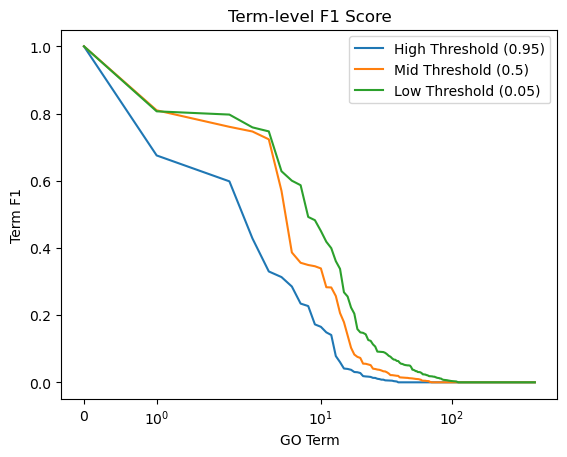

In [54]:
term_frequencies = train_labels.sum(axis=0)
from sklearn.metrics import f1_score
dvp = val_probs.toarray()

col_f1_l = []
for i in range(dvp.shape[1]):
    label_col = val_labels[:, i].astype(int)
    pred_col = dvp[:, i]
    col_f1 = f1_score(label_col, pred_col > 0.95)
    col_f1_l.append(col_f1)
col_f1_high = np.array(col_f1_l)

col_f1_l = []
for i in range(dvp.shape[1]):
    label_col = val_labels[:, i].astype(int)
    pred_col = dvp[:, i]
    col_f1 = f1_score(label_col, pred_col > 0.5)
    col_f1_l.append(col_f1)
col_f1_mid = np.array(col_f1_l)

col_f1_l = []
for i in range(dvp.shape[1]):
    label_col = val_labels[:, i].astype(int)
    pred_col = dvp[:, i]
    col_f1 = f1_score(label_col, pred_col > 0.05)
    col_f1_l.append(col_f1)
col_f1_low = np.array(col_f1_l)

subsample_frequencies = subsample_train_labels.sum(axis=0)
plt.plot(np.arange(subsample_frequencies.shape[0]), np.sort(col_f1_high)[::-1])
plt.plot(np.arange(subsample_frequencies.shape[0]), np.sort(col_f1_mid)[::-1])
plt.plot(np.arange(subsample_frequencies.shape[0]), np.sort(col_f1_low)[::-1])

plt.xlabel("GO Term")
plt.ylabel("Term F1")
plt.xscale('symlog')
plt.title("Term-level F1 Score")
plt.legend(["High Threshold (0.95)", "Mid Threshold (0.5)", "Low Threshold (0.05)"])
plt.show()

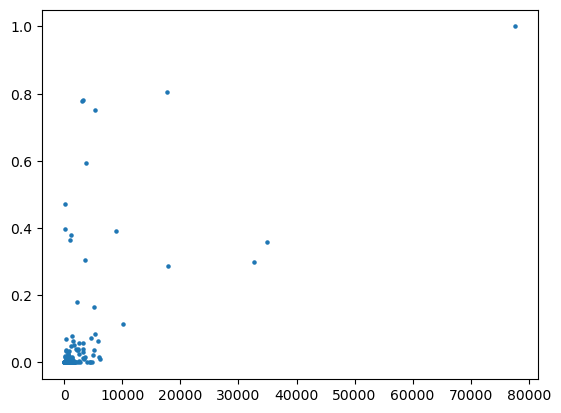

In [46]:
plt.scatter(subsample_frequencies, col_f1, s=5)
plt.show()

In [34]:
print(term_frequencies.shape)

(865,)


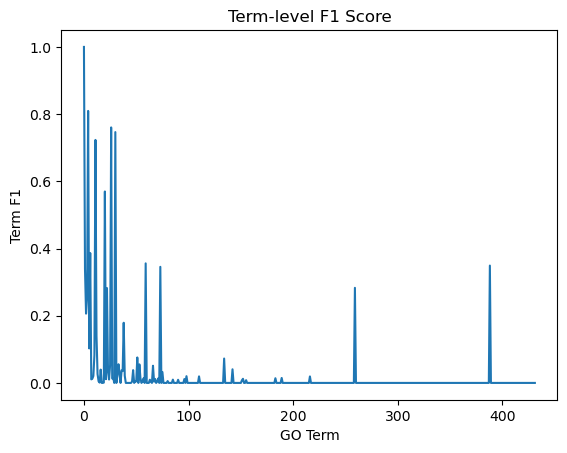

In [56]:
import pickle

with open("emb/rostlab_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/sample_finetune_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_sample_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/sample_finetune_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_sample_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/sample_finetune_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_sample_embeddings = emb_dict['prot_id'], emb_dict['embedding']

In [58]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support
def threshold_stats(testing_matrix, prediction_matrix):
    precs = []
    recs = []
    f_scores = []
    rms = []
    for threshold in np.linspace(0.001, 1, 100):
        preds = prediction_matrix.copy()
        preds.data = np.where(preds.data >= threshold, 1, 0)
        preds.eliminate_zeros()
        p, r, f, support = precision_recall_fscore_support(testing_matrix, preds, average='micro')
        precs.append(p)
        recs.append(r)
        f_scores.append(f)
        rms.append(r*r * preds.shape[0] * preds.shape[1] / preds.sum())
    return precs, recs, f_scores, rms


from go_metric.multilabel_knn import embedding_knn

train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()

subsample_train_labels = train_dataset.labels.toarray()[:, subsample_indices]
subsample_val_labels = val_dataset.labels.toarray()[:, subsample_indices]


In [ ]:
rostlab_preds = embedding_knn(train_embeddings, val_embeddings, subsample_train_labels, k=10)
precs, recs, f_scores1, rms = threshold_stats(csr_matrix(subsample_val_labels), csr_matrix(rostlab_preds))
plt.plot(precs, recs)

precs, recs, f_scores2, rms = threshold_stats(csr_matrix(subsample_val_labels), csr_matrix(val_probs))
plt.plot(precs, recs)

finetune_knn_preds = embedding_knn(train_sample_embeddings, val_sample_embeddings, subsample_train_labels, k=10)
precs, recs, f_scores3, rms = threshold_stats(csr_matrix(subsample_val_labels), csr_matrix(finetune_knn_preds))
plt.plot(precs, recs)


plt.title("Finetuning Performance (in-distribution)")
plt.legend([f"Rostlab Val (Max F1: {max(f_scores2):.2f})", f"Subsample Val (Max F1: {max(f_scores1):.2f})", ])
plt.show()